In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from IPython.display import Audio
from scipy import fft
import librosa
import librosa.display
# from wavinfo import WavInfoReader
import pandas as pd
import os
import sys
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models,layers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
def calculate_mfccs(waveform, samplingrate, number_coeffs=128):
    '''
    Caluculate Mel frequency cepstral coefficients.
    Input:
    waveform: array representing the waveform originating from audio file
    samplingrate: sampling rate from audio
    number_coeffs: total number of coefficients to calculate, default is 20
    Output: array of mfccs
    '''
    mfccs = librosa.feature.mfcc(y=waveform, sr=samplingrate,
                                 n_mfcc=number_coeffs)
    return mfccs


def calculate_specbandwidth(waveform, samplingrate, order_p=2):
    '''
    Calculates spectral bandwithd of oder p
    '''
    specbw = librosa.feature.spectral_bandwidth(y=waveform, sr=samplingrate,
                                                p=order_p)

    return specbw


def calculate_spectralcentroid(waveform, samplingrate, nfft=2048, hoplength=512):
    '''
    Calculate spectral centroid
    '''
    specent = librosa.feature.spectral_centroid(y=waveform,
                                                sr=samplingrate, n_fft=nfft,
                                                hop_length=hoplength)

    return specent


def calculate_chroma(waveform, samplingrate, nfft=2048, hoplength=512):
    '''
    Chroma Feature calculation with a hop length of 512 as default

    '''
    chromafeat = librosa.feature.chroma_stft(y=waveform, sr=samplingrate,
                                             n_fft=nfft,
                                             hop_length=hoplength)

    return chromafeat


def calculate_zerocrossrate(waveform, framelength=2048, hoplength=512,):
    '''
    Caluculate Zero crossing rate.

    '''
    zerocr = librosa.feature.zero_crossing_rate(y, frame_length=framelength,
                                                hop_length=hoplength)

    return zerocr


def calculate_spectralroff(waveform, samplingrate, nfft=2048, hoplength=512):
    '''
    Calculate spectral roll off of the waveform
    '''
    specroff = librosa.feature.spectral_rolloff(y=waveform,
                                                sr=samplingrate, n_fft=nfft,
                                                hop_length=hoplength)

    return specroff


In [ ]:
def read_audio(audiofile_path, samplingrate=22050, duration=None):
    '''
    Reading in audiofile, returns 1-dimensional array x, sampling rate sr
    '''

    x , sr = librosa.load(audiofile_path, sr=samplingrate, duration=duration)
    return x, sr


def calculate_spectogram(waveform, nfft=2048, hoplength=512):
    '''
    ===  1 Spectogram  ===
    requires 1-dimensional array x(timeseries), sampling rate sr
    returns spectogram, a matplotlib.colormesh object

    '''

    #performing short time- Fourier analysis
    X = librosa.stft(waveform, n_fft=nfft, hop_length=hoplength)

    #amplitudes of given frequency at given time -> spectrogram
    Xdb = librosa.amplitude_to_db(abs(X))

    #plt.figure(figsize=(6, 5), frameon=False)
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') # for demonstration purposes
    
#     spectogram = librosa.display.specshow(Xdb, sr=sr, x_axis=None, y_axis=None) # without axes
    
    return Xdb 

def calculate_melspect(waveform, samplingrate, nfft=2048, hoplength=512):
    
    melspec = librosa.feature.melspectrogram(y=waveform, sr=samplingrate, n_fft=nfft, hop_length=hoplength)
    
    melspec_dB = librosa.power_to_db(melspec)
    
    return melspec_dB


In [ ]:
def padding(feat_matrix, size, axis):
    
    padded = librosa.util.pad_center(feat_matrix, size=size, axis=axis)
    
    return padded


def padding_waveforms(waveforms, max_length=132300, axis=0):
    for idx, values in enumerate(waveforms):
        if values.shape[0] < max_length:
            waveforms[idx] = librosa.util.pad_center(waveforms[idx], size=max_length, axis=axis)
    
    return np.array(waveforms)  


def minmaxscaling(matrix):
    max_ = np.max(matrix)
    min_ = np.min(matrix)
    norm = np.array((matrix - min_)/(max_ - min_))
    
    return norm 


In [ ]:
def processing_drummers(dataframe):
    df_drummers = dataframe.drop(columns=['drummer', 'id', 'session', 'split', 'midi_filename'])
    df_drummers = df_drummers.dropna()
    df_drummers = df_drummers[df_drummers['beat_type'] == 'beat']
    df_drummers['style_new'] = df_drummers['style'].apply(lambda x: x.split('/')[0]) 
    df_drummers['style'] = df_drummers['style_new']
    
    return df_drummers.drop(columns='style_new')   


def process_audiofiles(loc, drummers_df, samplingrate=22050, duration=6):
    
    waveforms_ = drummers_df['audio_filename'].apply(
        lambda x: librosa.load(os.path.join(loc, x), sr=samplingrate, duration=duration)).values
    genres = drummers_df['style'].values    
    
    waveforms = []
    sr = []
    for values in waveforms_:
        waveforms.append(values[0])
        sr.append(values[1])
    
    waveforms_padded = padding_waveforms(waveforms, max_length=132300, axis=0) 
        
    return waveforms_padded, np.array(sr), genres


def spectogram_mfccs(waveform, sr):
    mfccs = []
    for idx in range(waveform.shape[0]):
        mfccs.append(calculate_mfccs(waveform[idx], sr[idx], number_coeffs=128)) # mfccs
    
    return np.array(mfccs)


def spectogram_chroma(waveform, sr):
    chroma = []    
    for idx in range(waveform.shape[0]):
        chroma.append(calculate_chroma(waveform[idx], samplingrate=sr[idx]))
    
    return np.array(chroma)
           

def spectogram_stft(waveform):
    spectogram_feat = []
    for idx in range(waveform.shape[0]):
        spectogram_feat.append(calculate_spectogram(waveform[idx]))
    
    return np.array(spectogram_feat)


def spectogram_mel(waveform, sr):
    melspect = [] 
    for idx in range(waveform.shape[0]):
        melspect.append(calculate_melspect(waveform[idx], samplingrate=sr[idx]))
    
    return np.array(melspect)


# def spectrograms(waveform, sr, how='all'):
#     shape_ = waveform.shape[0]
#     if how == 'all':
#         return spectogram_stft(waveform), spe
#         mfccs = []
#         for idx in range(shape_):
#             mfccs.append(calculate_mfccs(waveform[idx], sr[idx], number_coeffs=128)) # mfccs        
    

In [ ]:
# pwd = os.path.abspath('.')
# loc = os.path.join(pwd, '..', '..', '..' , 'drumbeatid', 'raw_data', 'groove')
# # loc_ = '../raw_data/groove/info.csv'
# loc

In [ ]:
loc = '/content/drive/MyDrive/Colab Notebooks/drumbeatid/raw_data/groove'
# os.chdir('/content/drive/MyDrive/Colab Notebooks/drumbeatid/raw_data/groove' )

In [ ]:
df = pd.read_csv(os.path.join(loc, 'info.csv'))
df.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


In [ ]:
df_drummers = processing_drummers(df)
df_drummers.head()

,style,bpm,beat_type,time_signature,audio_filename,duration
0,funk,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308
1,soul,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158
2,funk,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218
3,soul,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543
4,soul,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500


In [ ]:
df_drummers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 1133
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   style           444 non-null    object 
 1   bpm             444 non-null    int64  
 2   beat_type       444 non-null    object 
 3   time_signature  444 non-null    object 
 4   audio_filename  444 non-null    object 
 5   duration        444 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 24.3+ KB


In [ ]:
df_drummers.isnull().sum()

style             0
bpm               0
beat_type         0
time_signature    0
audio_filename    0
duration          0
dtype: int64

In [ ]:
df_drummers.groupby(by='style').count()

,bpm,beat_type,time_signature,audio_filename,duration
style,,,,,
afrobeat,4,4,4,4,4
afrocuban,7,7,7,7,7
blues,4,4,4,4,4
country,2,2,2,2,2
dance,5,5,5,5,5
funk,45,45,45,45,45
gospel,1,1,1,1,1
hiphop,32,32,32,32,32
jazz,50,50,50,50,50


In [ ]:
df_train, df_test = train_test_split(df_drummers, test_size=0.2, random_state=7)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 224 to 585
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   style           355 non-null    object 
 1   bpm             355 non-null    int64  
 2   beat_type       355 non-null    object 
 3   time_signature  355 non-null    object 
 4   audio_filename  355 non-null    object 
 5   duration        355 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 19.4+ KB


In [ ]:
df_train.shape

(355, 6)

In [ ]:
# slice_ = int(0.6 * df_train.shape[0])
# df_slice = df_train.iloc[0:slice_]
df_slice = df_train
df_slice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 224 to 585
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   style           355 non-null    object 
 1   bpm             355 non-null    int64  
 2   beat_type       355 non-null    object 
 3   time_signature  355 non-null    object 
 4   audio_filename  355 non-null    object 
 5   duration        355 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 19.4+ KB


In [ ]:
waveforms, sr, y = process_audiofiles(loc, df_slice)

In [ ]:
print(waveforms.shape)
print(sr.shape)
print(y.shape)

(355, 132300)
(355,)
(355,)


In [ ]:
mfccs = spectogram_mfccs(waveforms, sr)
spectogram_feat = spectogram_stft(waveforms)
melspect = spectogram_mel(waveforms, sr)
chroma = spectogram_chroma(waveforms, sr)

In [ ]:
print(mfccs.shape)
print(spectogram_feat.shape)
print(melspect.shape)
print(chroma.shape)

(355, 128, 259)
(355, 1025, 259)
(355, 128, 259)
(355, 12, 259)


In [ ]:
chroma_padded = padding(chroma, size=mfccs.shape[1], axis=1)
print(chroma_padded.shape)

(355, 128, 259)


In [ ]:
spectogram_feat_norm = minmaxscaling(spectogram_feat)
mfccs_norm = minmaxscaling(mfccs)
melspect_norm = minmaxscaling(melspect)
chroma_padded_norm = minmaxscaling(chroma_padded)
print(spectogram_feat_norm.shape)
print(mfccs_norm.shape)
print(melspect_norm.shape)
print(chroma_padded_norm.shape)

(355, 1025, 259)
(355, 128, 259)
(355, 128, 259)
(355, 128, 259)


In [ ]:
stacked = librosa.util.stack([mfccs_norm, melspect_norm, chroma_padded_norm], axis=3)
spectogram_feat_norm = np.expand_dims(spectogram_feat_norm, axis=-1)
print(stacked.shape)
spectogram_feat_norm.shape

(355, 128, 259, 3)


(355, 1025, 259, 1)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
y_cat = to_categorical(encoder.transform(y))
X_2 = stacked
X_1 = spectogram_feat_norm

In [ ]:
def initialize_CNNmodel_1(X, y):

    '''
    First CNN Architecture, simple to avoid overfitting.
    We should add up complication step-by-step.
    '''
    # For this dummy we have taken into account the mfccs size for height and width parameters
    input_shape=(X.shape[1:]) # (height, width, channels)
    CNNmodel = models.Sequential()
    CNNmodel.add(layers.Conv2D(32, kernel_size=(11, 11), activation='relu', input_shape=input_shape))
    CNNmodel.add(layers.MaxPooling2D(pool_size=(4, 4)))
    CNNmodel.add(layers.Conv2D(16, kernel_size=(7, 7), activation='relu'))
    CNNmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))
    CNNmodel.add(layers.Conv2D(8, kernel_size=(3, 3), activation='relu'))
    CNNmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))
    CNNmodel.add(layers.Flatten())
    CNNmodel.add(layers.Dense(32, activation='relu'))
#     CNNmodel.add(layers.Dense(y.shape[1], activation='softmax'))
    
#     CNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'f1score'])
    
    return CNNmodel

def initialize_CNNmodel_2(X, y):

    '''
    Second CNN Architecture, simple to avoid overfitting.
    We should add up complication step-by-step.
    '''
    # For this dummy we have taken into account the mfccs size for height and width parameters
    input_shape=(X.shape[1:]) # (height, width, channels)
    CNNmodel = models.Sequential()
    CNNmodel.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    CNNmodel.add(layers.MaxPooling2D(pool_size=(4, 4)))
    CNNmodel.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
    CNNmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))
    CNNmodel.add(layers.Conv2D(8, kernel_size=(3, 3), activation='relu'))
    CNNmodel.add(layers.MaxPooling2D(pool_size=(2, 2)))
    CNNmodel.add(layers.Flatten())
    CNNmodel.add(layers.Dense(32, activation='relu'))
#     CNNmodel.add(layers.Dense(y.shape[1], activation='softmax'))
    
#     CNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'f1score'])
    
    return CNNmodel

In [ ]:
# Define Inputs and Outputs of both CNN networks

CNNmodel_1 = initialize_CNNmodel_1(X_1, y_cat) # comment-out to keep pre-trained weights not to start from scratch
input_CNN_1 = CNNmodel_1.input
output_CNN_1 = CNNmodel_1.output

CNNmodel_2 = initialize_CNNmodel_2(X_2, y_cat) # comment-out to keep pre-trained weights not to start from scratch
input_CNN_2 = CNNmodel_2.input
output_CNN_2 = CNNmodel_2.output

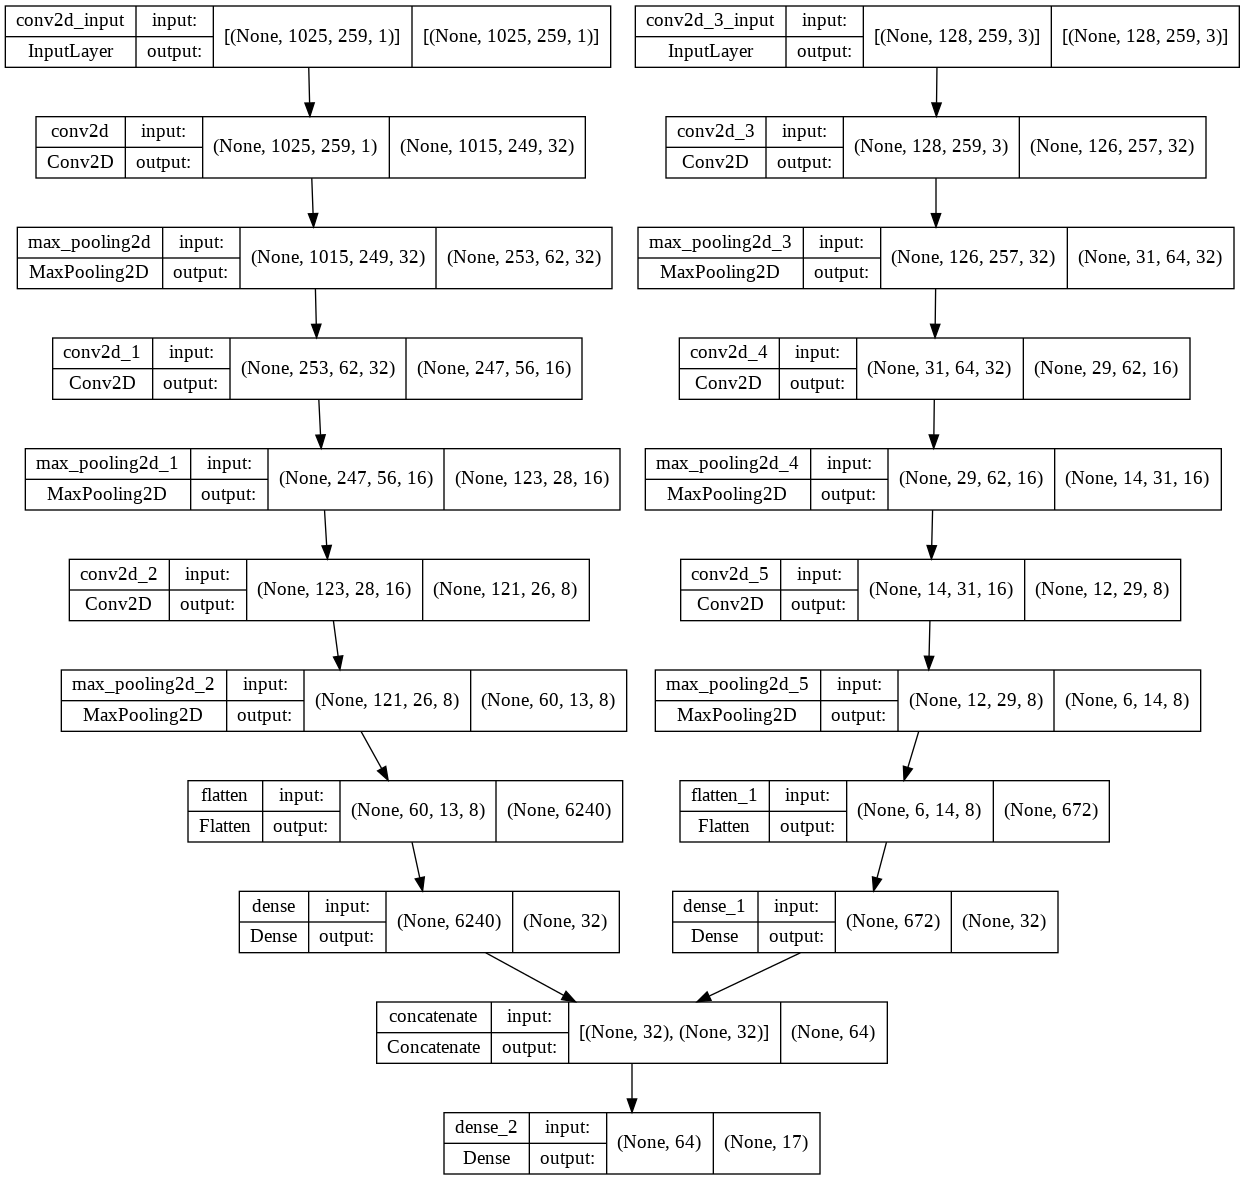

In [ ]:
# Let's combine the two streams of data and add two dense layers on top!
inputs = [input_CNN_1, input_CNN_2]

combined = layers.concatenate([output_CNN_1, output_CNN_2])

outputs = layers.Dense(y_cat.shape[1], activation="softmax")(combined)

CNNmodel_combined = models.Model(inputs=inputs, outputs=outputs)

plot_model(CNNmodel_combined, "multi_input_model.png", show_shapes=True)

In [ ]:
es = EarlyStopping(patience=25)

CNNmodel_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = CNNmodel_combined.fit(x=[X_1, X_2], y=y_cat, batch_size=16, validation_split=0.3, epochs=250, callbacks=[es])



Epoch 1/250
16/16 [==============================] - 7s 204ms/step - loss: 2.2445 - accuracy: 0.3871 - val_loss: 2.3332 - val_accuracy: 0.4019
Epoch 2/250
16/16 [==============================] - 2s 118ms/step - loss: 2.0578 - accuracy: 0.4113 - val_loss: 2.3726 - val_accuracy: 0.4019
Epoch 3/250
16/16 [==============================] - 2s 118ms/step - loss: 1.9951 - accuracy: 0.4113 - val_loss: 2.3432 - val_accuracy: 0.4019
Epoch 4/250
16/16 [==============================] - 2s 118ms/step - loss: 2.0044 - accuracy: 0.4113 - val_loss: 2.3220 - val_accuracy: 0.4019
Epoch 5/250
16/16 [==============================] - 2s 117ms/step - loss: 1.9776 - accuracy: 0.4113 - val_loss: 2.3817 - val_accuracy: 0.4019
Epoch 6/250
16/16 [==============================] - 2s 118ms/step - loss: 1.9555 - accuracy: 0.4113 - val_loss: 2.3828 - val_accuracy: 0.4019
Epoch 7/250
16/16 [==============================] - 2s 118ms/step - loss: 1.9600 - accuracy: 0.4113 - val_loss: 2.3410 - val_accuracy: 0.4019